In [1]:
from google.colab import files
uploaded = files.upload()

Saving listingsBoston.csv to listingsBoston.csv
Saving reviewsBoston.csv to reviewsBoston.csv


Importing necessary libraries

In [2]:
import pandas as pd
from sklearn.utils import resample
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from bs4 import BeautifulSoup
import re

listings = pd.read_csv(io.BytesIO(uploaded['listingsBoston.csv']))
reviews = pd.read_csv(io.BytesIO(uploaded['reviewsBoston.csv']))

# Data Cleaning

Checking all the attributes in the dataset


In [3]:
print(listings.columns)
print(reviews.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

Removing unnecessary attributes from the daatset

In [4]:
#Before Dropping
print(listings.shape)

listings = listings.drop(['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'calendar_updated','license','calendar_last_scraped'], axis=1)

#After dropping
print(listings.shape)

(4325, 75)
(4325, 59)


Price column has \$ symbol and cannot be processed as a numerical column. So, removing the \$ sign and converting it to float

In [5]:
# Ensure that the 'price' column is treated as a string first
listings['price'] = listings['price'].astype(str)

# Remove the $ symbol and commas using regex, then convert to numeric
listings['price'] = listings['price'].str.replace(r'[$,]', '', regex=True)

# Convert the cleaned 'price' column to a numeric type
listings['price'] = pd.to_numeric(listings['price'], errors='coerce')

# Check the result
print(listings['price'].head())
print(listings['price'].dtype)

0    125.0
1    139.0
2    179.0
3     92.0
4    130.0
Name: price, dtype: float64
float64


Checking if any of the numerical attributes have string or text data

In [6]:
# Convert the specified columns to numeric, coerce errors to NaN
cols_to_check = ['price','minimum_nights','maximum_nights','number_of_reviews','bedrooms', 'bathrooms', 'beds', 'accommodates',
                 'availability_30', 'availability_365', 'number_of_reviews_ltm','review_scores_rating']

# Function to check if values are non-numeric
def count_non_numeric(series):
    # This will return True for non-numeric values (strings or text)
    return series.apply(pd.to_numeric, errors='coerce').isna().sum()

# Apply the function to each column and get the count of non-numeric rows per column
non_numeric_counts = listings[cols_to_check].apply(count_non_numeric)

# Output the result
print("Number of rows with non-numeric values for each column:")
print(non_numeric_counts)



Number of rows with non-numeric values for each column:
price                    782
minimum_nights             0
maximum_nights             0
number_of_reviews          0
bedrooms                 210
bathrooms                782
beds                     804
accommodates               0
availability_30            0
availability_365           0
number_of_reviews_ltm      0
review_scores_rating     999
dtype: int64


Cleaning the text attributes room_type

In [7]:
# Remove leading/trailing spaces
listings['room_type'] = listings['room_type'].str.strip()

# Standardize text to lowercase
listings['room_type'] = listings['room_type'].str.lower()


Checking for missing values in the text attributes room_type and neighbourhood_cleansed

In [8]:
# Specify the columns to check for missing values
columns_to_check = ['room_type', 'neighbourhood_cleansed']

# Get the count of missing values for the specified columns
missing_values = listings[columns_to_check].isnull().sum()

# Display the number of missing values for these columns
print(missing_values)


room_type                 0
neighbourhood_cleansed    0
dtype: int64


Converting the amenities in each row into a numerical attribute in order to be used for further analysis.

In [9]:
# Function to clean and count the number of amenities in each record
def count_amenities(amenities_str):
    # Decode special characters and remove unnecessary characters like quotes, square brackets, etc.
    cleaned_amenities_str = amenities_str.encode('utf-8').decode('unicode_escape').strip('[]').replace('"', '')

    # Split the cleaned string into a list of amenities
    amenities_list = cleaned_amenities_str.split(', ')

    # Return the count of amenities
    return len(amenities_list)

# Apply the function to each record in the 'amenities' column
listings['amenities_count'] = listings['amenities'].apply(lambda x: count_amenities(x))

# Display the updated DataFrame with the new column
print(listings[['amenities', 'amenities_count']])

                                              amenities  amenities_count
0     ["Central air conditioning", "Free street park...               28
1     ["Fire extinguisher", "Free street parking", "...               29
2     ["Fire extinguisher", "Free street parking", "...               29
3     ["Fire extinguisher", "Bed linens", "Long term...               33
4     ["Fire extinguisher", "Bed linens", "Long term...               22
...                                                 ...              ...
4320  ["Mini fridge", "Fire extinguisher", "Bed line...               27
4321  ["Mini fridge", "Fire extinguisher", "Bed line...               25
4322  ["Mini fridge", "Fire extinguisher", "Bed line...               26
4323  ["Laundromat nearby", "Fire extinguisher", "Di...               47
4324  ["Smoke alarm", "Dedicated workspace", "First ...               13

[4325 rows x 2 columns]


# Descriptive Statistics

Calculate summary statistics for numerical features such as `price`,
`minimum_nights`, `maximum_nights`, `number_of_reviews`, and
`review_scores_rating`. Understand the central tendency, dispersion, and
distribution of these variables.

In [10]:
# List of numerical features to analyze
numerical_features = ['price','minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating']

# Additional features for analysis
additional_numerical_features = ['accommodates','availability_30', 'availability_365', 'number_of_reviews_ltm']

Removing null values from the required numerical features

In [11]:
# Convert columns to numeric, invalid parsing will be set as NaN
listings[numerical_features] = listings[numerical_features].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns (i.e., non-numeric values)
listings_1 = listings.dropna(subset=numerical_features)

# Check the DataFrame to ensure non-numeric values have been removed
print(listings_1)

# Verify that all specified columns are numerical
print(listings_1[numerical_features].dtypes)

                       id                                              name  \
0                    3781                         HARBORSIDE-Walk to subway   
1                    5506    ** Fort Hill Inn Private! Minutes to center!**   
2                    6695     Fort Hill Inn *Sunny* 1 bedroom, condo duplex   
3                    8789               Curved Glass Studio/1bd facing Park   
4                   10811  Back Bay Apt Studio-3 blocks to Pru center & "T"   
...                   ...                                               ...   
4286  1175344947100869764               Huge Studio in Downtown Boston 1409   
4292  1176861035408746030          Cozy Boston studio with separate bedroom   
4293  1177103248225483462    Stylish studio with room divider near downtown   
4296  1177619455488589855                        Luxury South End 1 Bedroom   
4301  1178933965841931292   Best Location, 1 bedroom Apartment, Beacon Hill   

                                            descrip

Calculating the summary statistics for the required numerical values

In [12]:
def display_summary_statistics(dataframe, numerical_features):
    # Calculate summary statistics
    summary_statistics = dataframe[numerical_features].describe()

    # Display the summary statistics
    print("Summary Statistics:")
    print(summary_statistics)

numerical_features = ['price', 'minimum_nights','maximum_nights', 'review_scores_rating']
display_summary_statistics(listings_1, numerical_features)


Summary Statistics:
             price  minimum_nights  maximum_nights  review_scores_rating
count  2774.000000     2774.000000     2774.000000           2774.000000
mean    232.056957       16.556957      539.816510              4.717909
std     203.032961       26.234775      420.881163              0.432748
min      25.000000        1.000000        3.000000              1.000000
25%     112.000000        1.000000      360.000000              4.660000
50%     190.000000        2.000000      365.000000              4.830000
75%     284.000000       29.000000     1125.000000              4.970000
max    4786.000000      365.000000     1125.000000              5.000000


Removing null values from the additional numerical features

In [13]:
# Convert columns to numeric, invalid parsing will be set as NaN
listings[additional_numerical_features] = listings[additional_numerical_features].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns (i.e., non-numeric values)
listings_2 = listings.dropna(subset=additional_numerical_features)

# Check the DataFrame to ensure non-numeric values have been removed
print(listings_2)

# Verify that all specified columns are numerical
print(listings_2[additional_numerical_features].dtypes)

                       id                                              name  \
0                    3781                         HARBORSIDE-Walk to subway   
1                    5506    ** Fort Hill Inn Private! Minutes to center!**   
2                    6695     Fort Hill Inn *Sunny* 1 bedroom, condo duplex   
3                    8789               Curved Glass Studio/1bd facing Park   
4                   10811  Back Bay Apt Studio-3 blocks to Pru center & "T"   
...                   ...                                               ...   
4320  1181310640039457019        The Chester: Modern Luxury, Historic Charm   
4321  1181310920532325010         The Chester:  Urban Luxury, Modern Design   
4322  1181311064422167794     The Chester: Modern, Cool, Heart Of South End   
4323  1182535715185750063                                Luxury one bedroom   
4324  1183366210963015944       Large 4 Bedroom apartments, 2RD FL/Brighton   

                                            descrip

Calculating the summary statistics for the additional numerical features

In [30]:
display_summary_statistics(listings_2, additional_numerical_features)

Summary Statistics:
       accommodates  availability_30  availability_365  number_of_reviews_ltm
count   4325.000000      4325.000000       4325.000000            4325.000000
mean       3.258728        10.130173        191.822197              11.560462
std        2.345380        10.698757        125.982783              19.785549
min        1.000000         0.000000          0.000000               0.000000
25%        2.000000         0.000000         78.000000               0.000000
50%        2.000000         6.000000        200.000000               2.000000
75%        4.000000        20.000000        311.000000              15.000000
max       16.000000        30.000000        365.000000             221.000000


Calculating the values variance, skewness, kurtosis for understanding the central tendency, dispersion

In [15]:
# Calculate variance
variance_values1 = listings_1[numerical_features].var()
variance_values2 = listings_2[additional_numerical_features].var()
print("\nVariance Values:")
print(variance_values1)
print(variance_values2)

# Calculate skewness
skewness_values1 = listings_1[numerical_features].skew()
skewness_values2 = listings_2[additional_numerical_features].skew()
print("\nSkewness Values:")
print(skewness_values1)
print(skewness_values2)

# Calculate kurtosis
kurtosis_values1 = listings_1[numerical_features].kurt()
kurtosis_values2 = listings_2[additional_numerical_features].kurt()
print("\nKurtosis Values:")
print(kurtosis_values1)
print(kurtosis_values2)


Variance Values:
price                    41222.383340
minimum_nights             688.263433
maximum_nights          177140.953337
review_scores_rating         0.187271
dtype: float64
accommodates                 5.500806
availability_30            114.463393
availability_365         15871.661487
number_of_reviews_ltm      391.467955
dtype: float64

Skewness Values:
price                   5.987090
minimum_nights          3.400792
maximum_nights          0.456073
review_scores_rating   -4.629216
dtype: float64
accommodates             2.195010
availability_30          0.647494
availability_365        -0.172350
number_of_reviews_ltm    2.824941
dtype: float64

Kurtosis Values:
price                   97.841231
minimum_nights          22.242211
maximum_nights          -1.385313
review_scores_rating    30.726622
dtype: float64
accommodates              6.646466
availability_30          -1.075702
availability_365         -1.391711
number_of_reviews_ltm    11.911036
dtype: float64


# 2. Distribution Analysis

Plot histograms or density plots for key numerical features like price,minimum_nights, and review_scores_rating. Analyze the distribution of these features to identify any skewness or outliers.

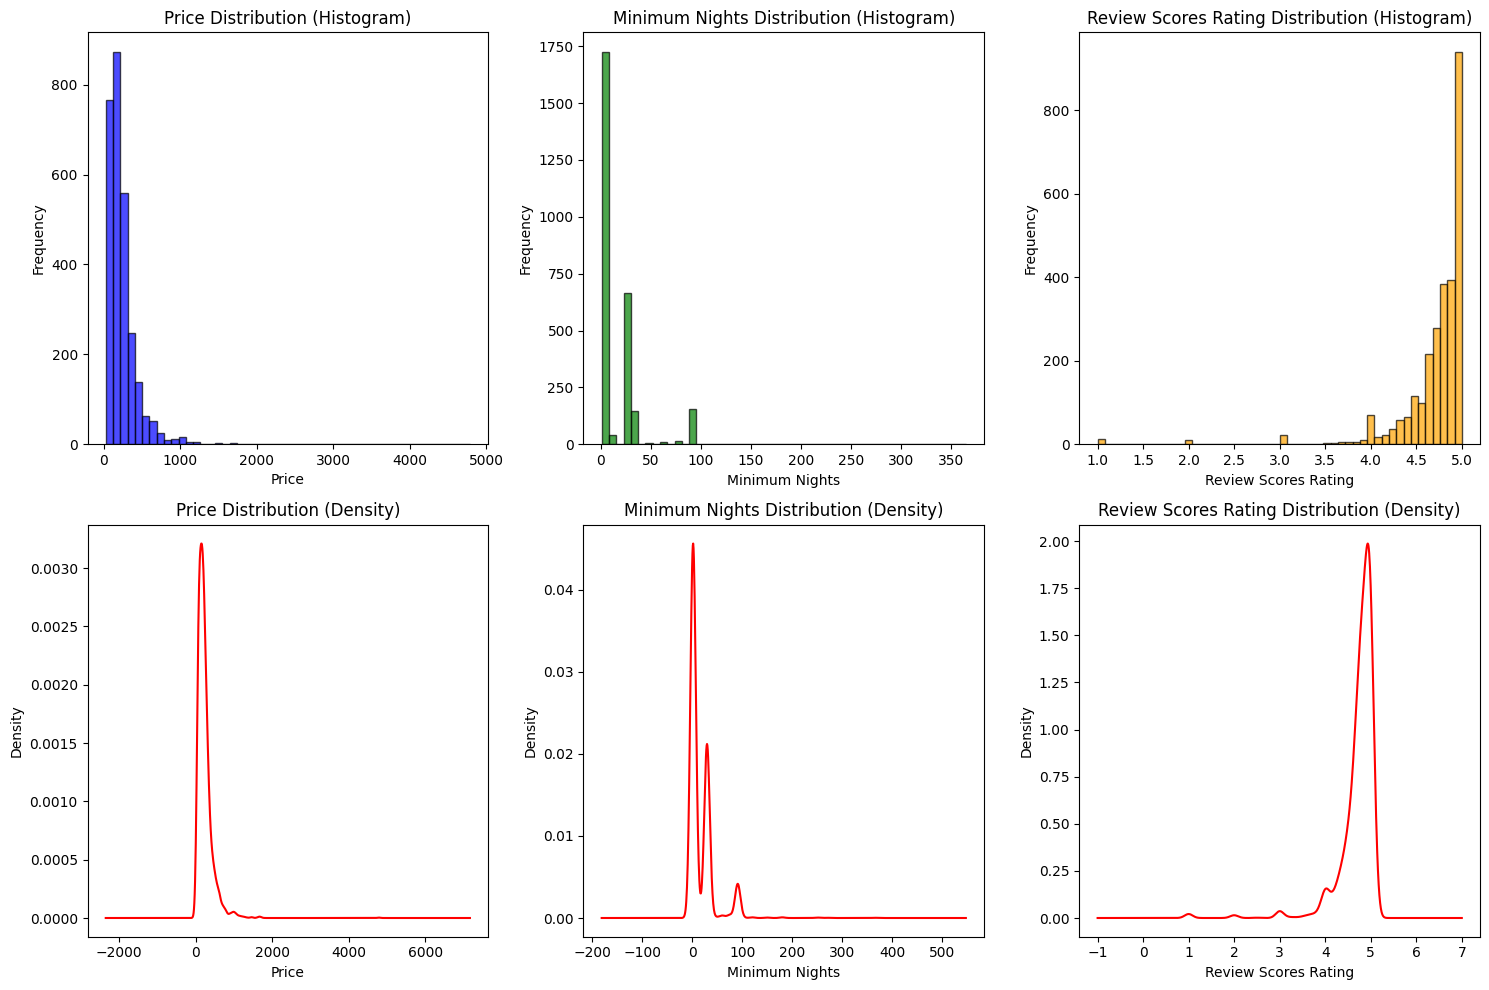

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_numerical_distributions(dataframe):
    """
    Plot histograms and density plots for key numerical features in the DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the numerical features.
    """
    plt.figure(figsize=(15, 10))

    # Price histogram
    plt.subplot(2, 3, 1)
    plt.hist(dataframe['price'], bins=50, color='blue', edgecolor='black', alpha=0.7)
    plt.title('Price Distribution (Histogram)')
    plt.xlabel('Price')
    plt.ylabel('Frequency')

    # Price density plot
    plt.subplot(2, 3, 4)
    dataframe['price'].plot(kind='kde', color='red')
    plt.title('Price Distribution (Density)')
    plt.xlabel('Price')
    plt.ylabel('Density')

    # Minimum nights histogram
    plt.subplot(2, 3, 2)
    plt.hist(dataframe['minimum_nights'], bins=50, color='green', edgecolor='black', alpha=0.7)
    plt.title('Minimum Nights Distribution (Histogram)')
    plt.xlabel('Minimum Nights')
    plt.ylabel('Frequency')

    # Minimum nights density plot
    plt.subplot(2, 3, 5)
    dataframe['minimum_nights'].plot(kind='kde', color='red')
    plt.title('Minimum Nights Distribution (Density)')
    plt.xlabel('Minimum Nights')
    plt.ylabel('Density')

    # Review scores rating histogram
    plt.subplot(2, 3, 3)
    plt.hist(dataframe['review_scores_rating'].dropna(), bins=50, color='orange', edgecolor='black', alpha=0.7)
    plt.title('Review Scores Rating Distribution (Histogram)')
    plt.xlabel('Review Scores Rating')
    plt.ylabel('Frequency')

    # Review scores rating density plot
    plt.subplot(2, 3, 6)
    dataframe['review_scores_rating'].dropna().plot(kind='kde', color='red')
    plt.title('Review Scores Rating Distribution (Density)')
    plt.xlabel('Review Scores Rating')
    plt.ylabel('Density')

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_numerical_distributions(listings_1)


# 3. Correlation Analysis

Create a correlation matrix to explore relationships between numerical variables such as price, number_of_reviews, availability_365, and review_scores_rating. Identify any strong correlations that might be useful for predictive modeling or further investigation.

Plotting correlation matrix and heatmap for the required attributes

Plotting correlation matrix and heatmap for additional attributes

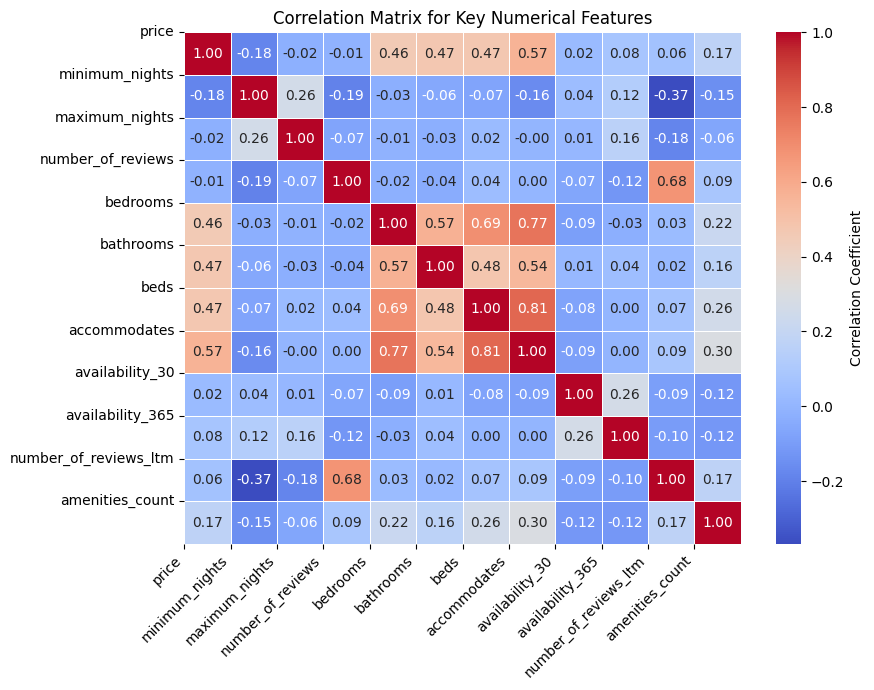

,price,minimum_nights,maximum_nights,number_of_reviews,bedrooms,bathrooms,beds,accommodates,availability_30,availability_365,number_of_reviews_ltm,amenities_count
price,1.000000,-0.182724,-0.024558,-0.011389,0.459275,0.473013,0.473033,0.565313,0.023132,0.075780,0.063711,0.168389
minimum_nights,-0.182724,1.000000,0.260937,-0.193912,-0.029112,-0.056926,-0.073671,-0.160607,0.037951,0.124627,-0.368127,-0.152794
maximum_nights,-0.024558,0.260937,1.000000,-0.069877,-0.011508,-0.029384,0.024230,-0.002287,0.009379,0.159936,-0.184690,-0.064230
number_of_reviews,-0.011389,-0.193912,-0.069877,1.000000,-0.022455,-0.038147,0.037638,0.000854,-0.068148,-0.124130,0.676651,0.085034
bedrooms,0.459275,-0.029112,-0.011508,-0.022455,1.000000,0.572273,0.691546,0.772395,-0.092243,-0.031137,0.028829,0.219373
bathrooms,0.473013,-0.056926,-0.029384,-0.038147,0.572273,1.000000,0.479956,0.540758,0.013486,0.039116,0.016784,0.163764
beds,0.473033,-0.073671,0.024230,0.037638,0.691546,0.479956,1.000000,0.809984,-0.076225,0.004190,0.066433,0.256011
accommodates,0.565313,-0.160607,-0.002287,0.000854,0.772395,0.540758,0.809984,1.000000,-0.086360,0.000595,0.085427,0.297846
availability_30,0.023132,0.037951,0.009379,-0.068148,-0.092243,0.013486,-0.076225,-0.086360,1.000000,0.263371,-0.091214,-0.118592
availability_365,0.075780,0.124627,0.159936,-0.124130,-0.031137,0.039116,0.004190,0.000595,0.263371,1.000000,-0.102128,-0.120328


In [17]:
#List of columns
correlation_columns = ['price','minimum_nights','maximum_nights','number_of_reviews','bedrooms','bathrooms','beds','accommodates','availability_30','availability_365','number_of_reviews_ltm','amenities_count']

# Convert columns to numeric, invalid parsing will be set as NaN
listings[correlation_columns] = listings[correlation_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns
listings_4 = listings_1.dropna(subset=correlation_columns)

# Creating the correlation matrix
correlation_matrix = listings_4[correlation_columns].corr()

# Plotting the correlation matrix using a heatmap with annotations
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})

# Formatting the heatmap
plt.xticks(range(len(correlation_columns)), correlation_columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_columns)), correlation_columns)
plt.title('Correlation Matrix for Key Numerical Features')

# Show the plot
plt.tight_layout()
plt.show()

# Displaying the correlation matrix
correlation_matrix


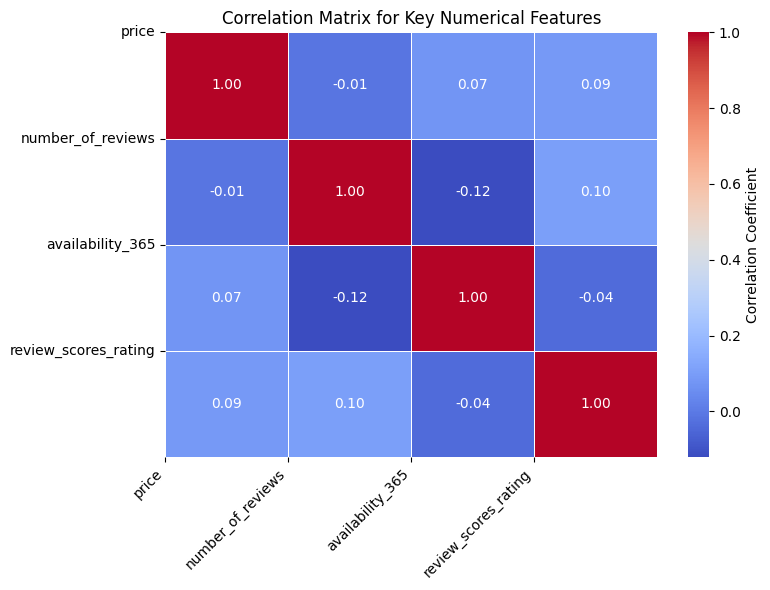

,price,number_of_reviews,availability_365,review_scores_rating
price,1.000000,-0.012124,0.072772,0.088569
number_of_reviews,-0.012124,1.000000,-0.121182,0.102351
availability_365,0.072772,-0.121182,1.000000,-0.039902
review_scores_rating,0.088569,0.102351,-0.039902,1.000000


In [18]:
#List of columns
correlation_columns = ['price', 'number_of_reviews', 'availability_365', 'review_scores_rating']

# Convert columns to numeric, invalid parsing will be set as NaN
listings[correlation_columns] = listings[correlation_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns
listings_3 = listings_1.dropna(subset=correlation_columns)

# Creating the correlation matrix
correlation_matrix = listings_3[correlation_columns].corr()

# Plotting the correlation matrix using a heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})

# Formatting the heatmap
plt.xticks(range(len(correlation_columns)), correlation_columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_columns)), correlation_columns)
plt.title('Correlation Matrix for Key Numerical Features')

# Show the plot
plt.tight_layout()
plt.show()

# Displaying the correlation matrix
correlation_matrix

# 4. Price Analysis

Analyze the distribution of prices across different neighborhoods (host_neighbourhood) or room types (if available). Understand which neighborhoods have higher or lower average prices and whether certain neighborhoods are more popular for shortterm or longterm stays.

In [19]:
listings['stay_type'] = listings['minimum_nights'].apply(lambda x: 'Long-term' if x > 30 else 'Short-term')

# Extracting relevant columns for price analysis: price, neighbourhood_cleansed, room_type, and minimum_nights
price_analysis_columns = ['price', 'neighbourhood_cleansed', 'room_type', 'minimum_nights', 'maximum_nights', 'stay_type']

# Creating the price_analysis_data DataFrame
price_analysis_data = listings[price_analysis_columns].dropna()

# Calculating average price per neighborhood
avg_price_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)

# Calculating average minimum/maximum nights per neighborhood (to understand short-term vs long-term stays)
avg_minimum_nights_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['minimum_nights'].mean().sort_values(ascending=False)
avg_maximum_nights_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['maximum_nights'].mean().sort_values(ascending=False)

# Calculating average price per room type
avg_price_room_type = price_analysis_data.groupby('room_type')['price'].mean().sort_values(ascending=False)

# Calculate average price for short-term and long-term stays by neighborhood
avg_price_neighbourhood_stay_type = price_analysis_data.groupby(['neighbourhood_cleansed', 'stay_type'])['price'].mean().unstack().fillna(0)

# Calculate average price for short-term and long-term stays by room type
avg_price_room_type_stay_type = price_analysis_data.groupby(['room_type', 'stay_type'])['price'].mean().unstack().fillna(0)

# Displaying the results
print("Average Price by Neighborhood:")
print(avg_price_neighbourhood)

print("\nAverage Minimum Nights by Neighborhood:")
print(avg_minimum_nights_neighbourhood)

print("\nAverage Maximum Nights by Neighborhood:")
print(avg_maximum_nights_neighbourhood)

print("\nAverage Price by Room Type:")
print(avg_price_room_type)

print("\nAverage Price by Neighborhood and Stay Type:")
print(avg_price_neighbourhood_stay_type)

print("\nAverage Price by Room Type and Stay Type:")
print(avg_price_room_type_stay_type)

Average Price by Neighborhood:
neighbourhood_cleansed
Bay Village                501.910256
Longwood Medical Area      433.285714
Downtown                   349.513678
Back Bay                   320.277612
Leather District           306.375000
South Boston Waterfront    297.181818
Charlestown                296.276923
Fenway                     291.986726
South End                  276.657143
Chinatown                  276.617647
West End                   260.076923
North End                  255.392157
Beacon Hill                247.161850
South Boston               238.172619
Jamaica Plain              211.040541
East Boston                201.633987
Roxbury                    181.404412
West Roxbury               173.865672
Brighton                   165.736170
Dorchester                 155.123853
Allston                    150.791667
Mission Hill               150.450000
Roslindale                 147.126761
Hyde Park                  131.755102
Mattapan                   122.431

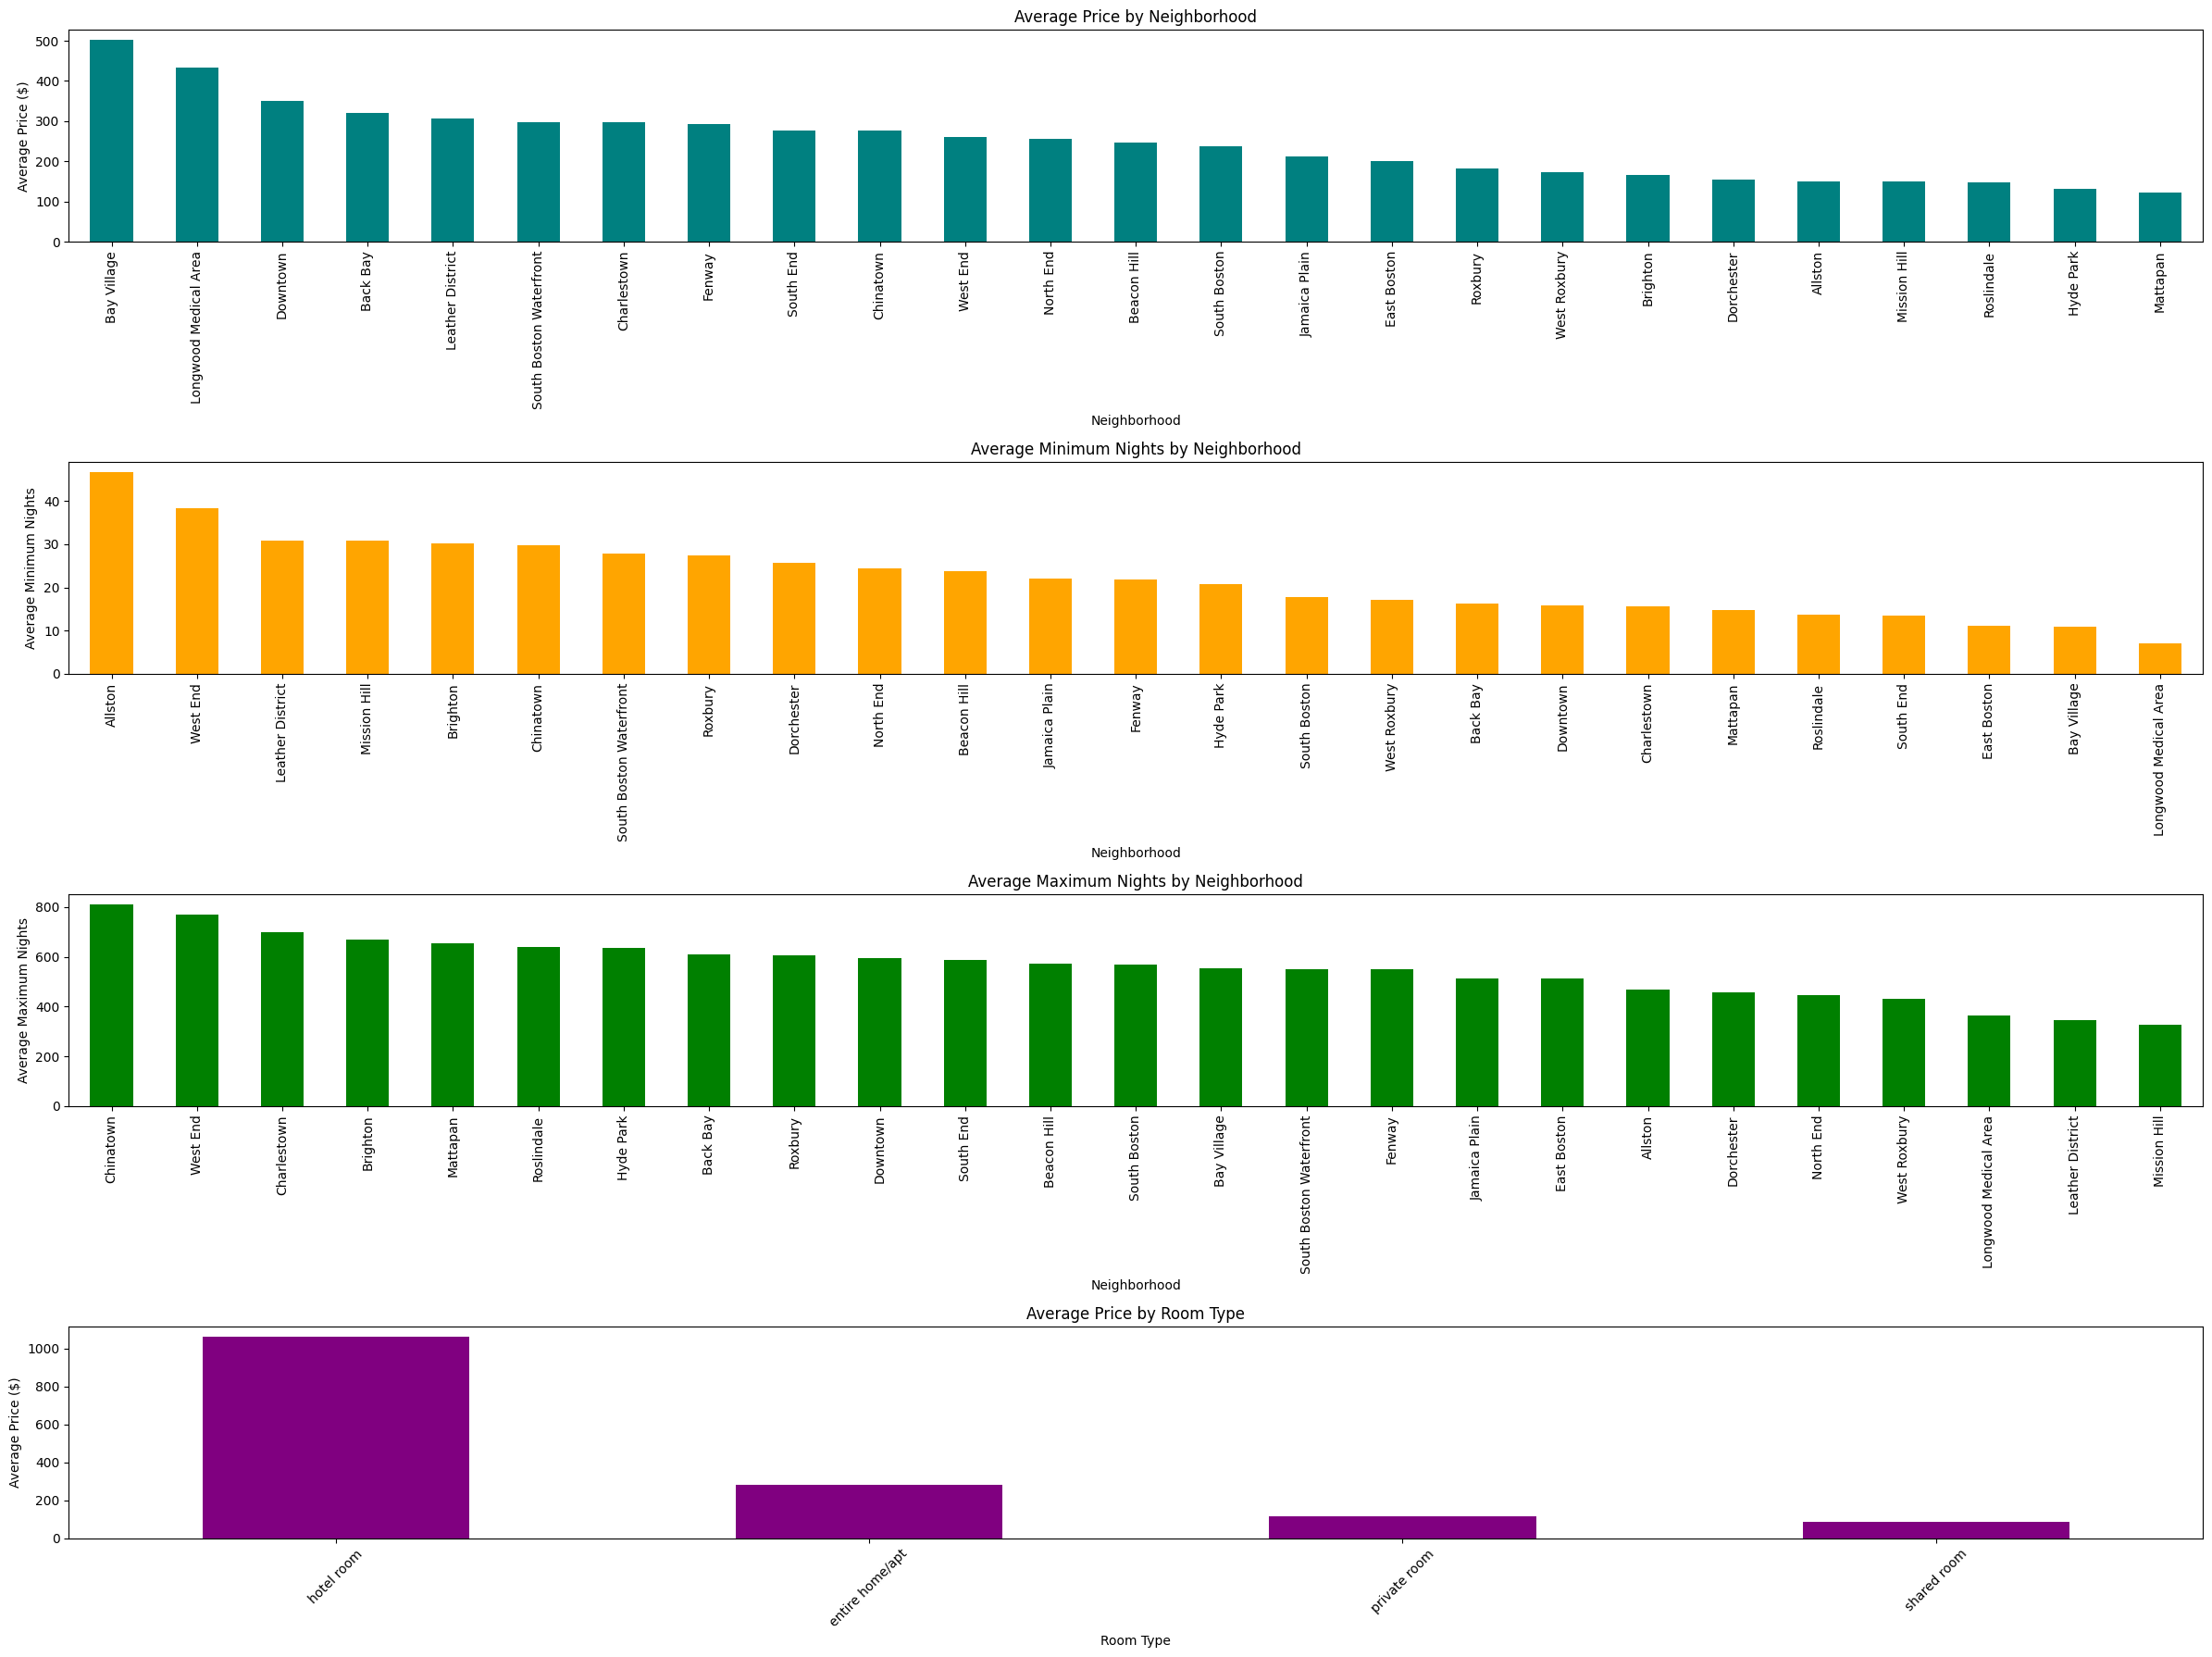

In [20]:
# Plotting price and minimum nights distributions across neighborhoods and room types
plt.figure(figsize=(24, 18))

# Average price by neighborhood
plt.subplot(4, 1, 1)
avg_price_neighbourhood.plot(kind='bar', color='teal')
plt.title('Average Price by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=90)

# Average minimum nights by neighborhood
plt.subplot(4, 1, 2)
avg_minimum_nights_neighbourhood.plot(kind='bar', color='orange')
plt.title('Average Minimum Nights by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Minimum Nights')
plt.xticks(rotation=90)

# Average maximum nights by neighborhood
plt.subplot(4, 1, 3)
avg_maximum_nights_neighbourhood.plot(kind='bar', color='green')
plt.title('Average Maximum Nights by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Maximum Nights')
plt.xticks(rotation=90)

# Average price by room type
plt.subplot(4, 1, 4)
avg_price_room_type.plot(kind='bar', color='purple')
plt.title('Average Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<Figure size 1600x800 with 0 Axes>

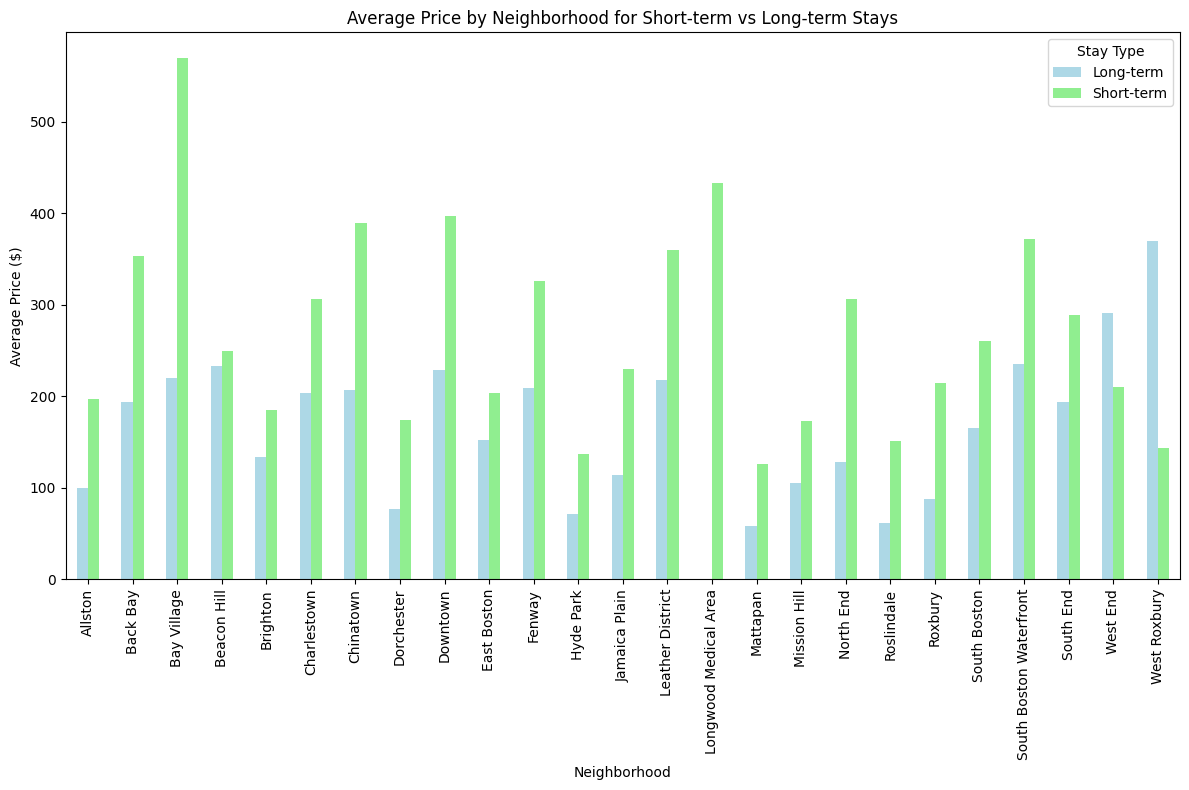

<Figure size 800x600 with 0 Axes>

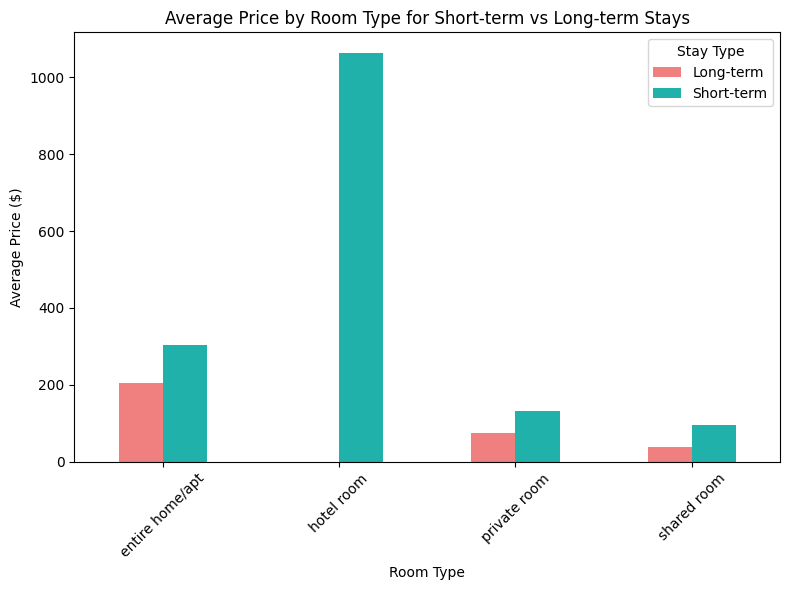

In [21]:
# Plotting average price by neighborhood for short-term and long-term stays
plt.figure(figsize=(16, 8))

# Average price by neighborhood for short-term and long-term stays
avg_price_neighbourhood_stay_type.plot(kind='bar', stacked=False, color=['lightblue', 'lightgreen'], figsize=(12, 8))
plt.title('Average Price by Neighborhood for Short-term vs Long-term Stays')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=90)
plt.legend(title='Stay Type')

plt.tight_layout()
plt.show()

# Plotting average price by room type for short-term and long-term stays
plt.figure(figsize=(8, 6))

# Average price by room type for short-term and long-term stays
avg_price_room_type_stay_type.plot(kind='bar', stacked=False, color=['lightcoral', 'lightseagreen'], figsize=(8, 6))
plt.title('Average Price by Room Type for Short-term vs Long-term Stays')
plt.xlabel('Room Type')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)
plt.legend(title='Stay Type')

plt.tight_layout()
plt.show()

# 5. Neighborhood Comparison

Compare the average review_scores_rating across different neighborhoods. Determine if certain neighborhoods have consistently higher ratings, which could indicate better or worse guest experiences.

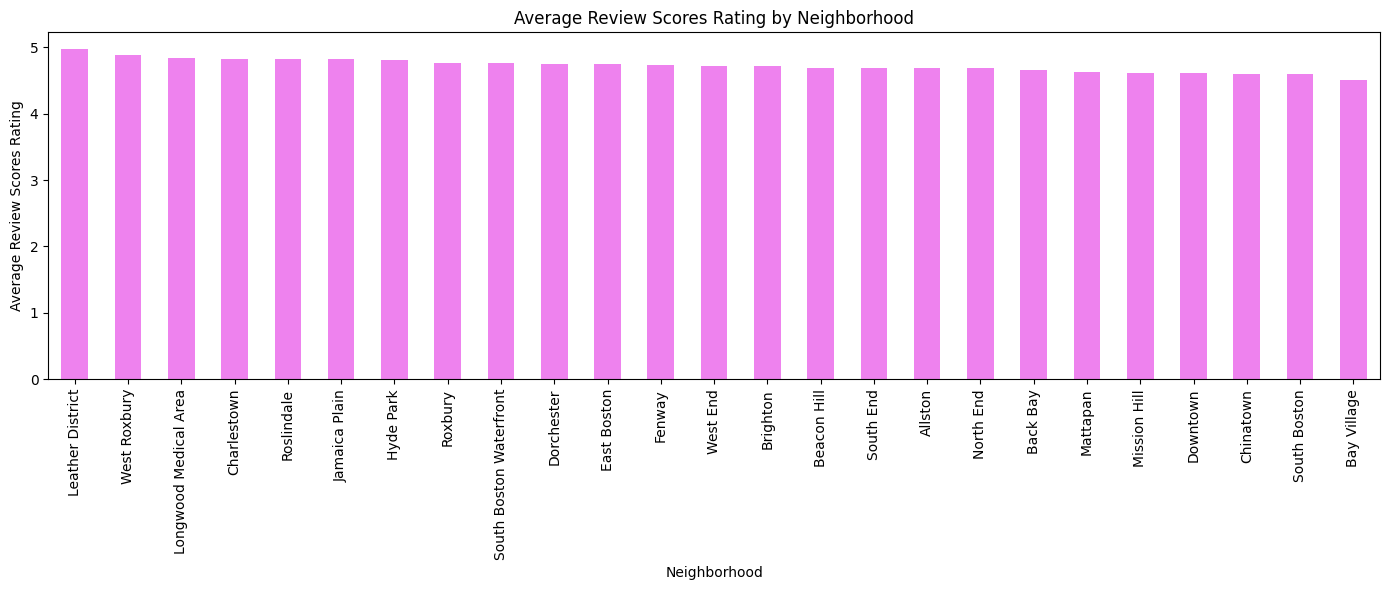

Average Review Scores Rating by Neighborhood:
neighbourhood_cleansed
Leather District           4.976667
West Roxbury               4.884062
Longwood Medical Area      4.837778
Charlestown                4.829595
Roslindale                 4.823457
Jamaica Plain              4.821421
Hyde Park                  4.811803
Roxbury                    4.763158
South Boston Waterfront    4.758889
Dorchester                 4.745890
East Boston                4.741304
Fenway                     4.736667
West End                   4.722286
Brighton                   4.718173
Beacon Hill                4.693806
South End                  4.692590
Allston                    4.691964
North End                  4.686180
Back Bay                   4.665086
Mattapan                   4.623871
Mission Hill               4.620213
Downtown                   4.612024
Chinatown                  4.603256
South Boston               4.599936
Bay Village                4.501731
Name: review_scores_rating, dty

In [22]:
# Calculating average review_scores_rating per neighborhood
avg_rating_neighbourhood = listings.groupby('neighbourhood_cleansed')['review_scores_rating'].mean().dropna().sort_values(ascending=False)

# Plotting the average review_scores_rating across neighborhoods
plt.figure(figsize=(14, 6))
avg_rating_neighbourhood.plot(kind='bar', color='violet')
plt.title('Average Review Scores Rating by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Review Scores Rating')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Display the average review scores rating per neighborhood
print("Average Review Scores Rating by Neighborhood:")
print(avg_rating_neighbourhood)

# 6. Outlier Detection

Identify outliers in the dataset, particularly in price, minimum_nights, and review_scores_rating.

# Detecting outliers using IQR

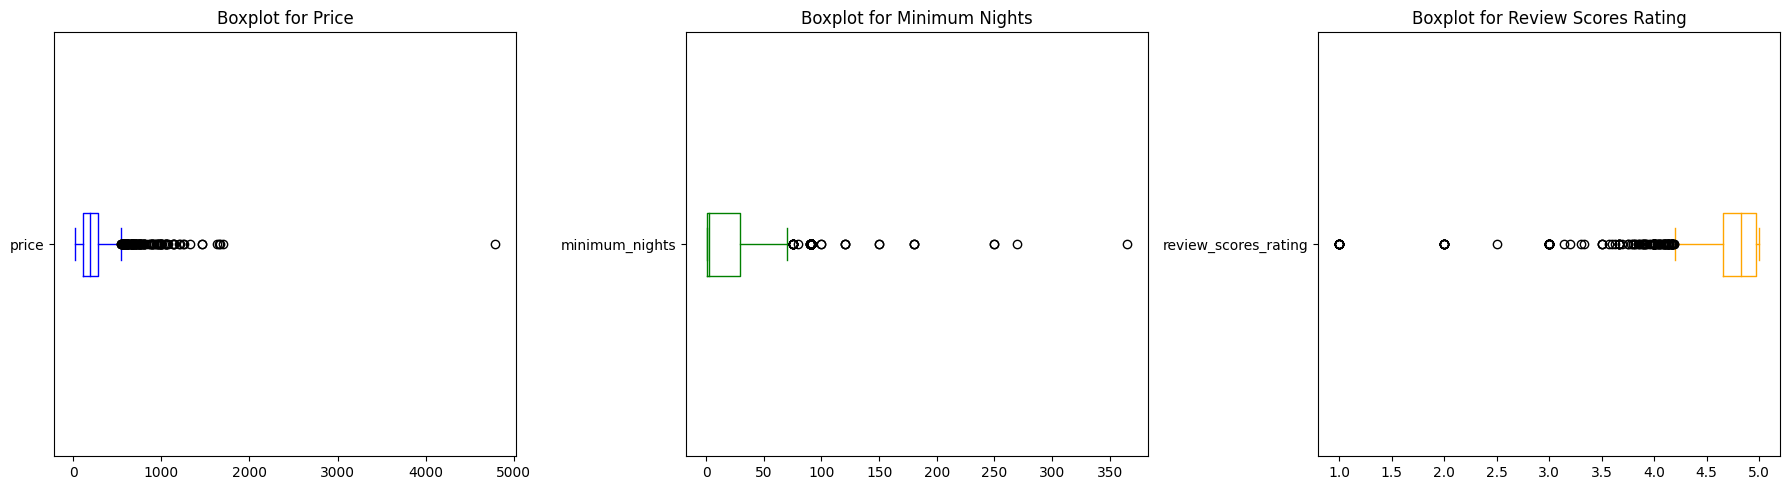

Number of price outliers: 160
      price
61    571.0
86    985.0
100   571.0
187   600.0
190   900.0
...     ...
4123  743.0
4124  857.0
4125  721.0
4215  699.0
4301  975.0

[160 rows x 1 columns]

Number of minimum nights outliers: 182
      minimum_nights
3                 91
4                 91
45                91
53                91
59                91
...              ...
3204              91
3257              91
3267              91
3301              91
3321              91

[182 rows x 1 columns]

Number of review scores rating outliers: 190
      review_scores_rating
6                     4.00
87                    4.00
166                   4.00
221                   3.67
281                   4.14
...                    ...
4256                  4.00
4262                  1.00
4263                  4.00
4269                  4.00
4275                  1.00

[190 rows x 1 columns]

Total number of outliers detected: 510
                       id                           

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming listings_1 is your original DataFrame
# List of columns to check for outliers
outlier_columns = ['price', 'minimum_nights', 'review_scores_rating']

# Function to detect outliers using IQR
def detect_outliers_iqr(listings, column):
    Q1 = listings[column].quantile(0.25)
    Q3 = listings[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = listings[(listings[column] < lower_bound) | (listings[column] > upper_bound)]
    return outliers

# Detecting outliers for each column and storing them in separate DataFrames
outliers_price = detect_outliers_iqr(listings_1, 'price')
outliers_minimum_nights = detect_outliers_iqr(listings_1, 'minimum_nights')
outliers_review_scores = detect_outliers_iqr(listings_1, 'review_scores_rating')

# Combine all outliers into one DataFrame
all_outliers = pd.concat([outliers_price, outliers_minimum_nights, outliers_review_scores]).drop_duplicates()

# Create a DataFrame without outliers
listings_no_outliers_IQR = listings_1[~listings_1.index.isin(all_outliers.index)]

# Visualizing outliers with boxplots
plt.figure(figsize=(18, 5))

# Boxplot for price
plt.subplot(1, 3, 1)
listings_1['price'].plot(kind='box', vert=False, color='blue')
plt.title('Boxplot for Price')

# Boxplot for minimum nights
plt.subplot(1, 3, 2)
listings_1['minimum_nights'].plot(kind='box', vert=False, color='green')
plt.title('Boxplot for Minimum Nights')

# Boxplot for review scores rating
plt.subplot(1, 3, 3)
listings_1['review_scores_rating'].plot(kind='box', vert=False, color='orange')
plt.title('Boxplot for Review Scores Rating')

plt.tight_layout()
plt.show()

# Display the number of outliers
print(f"Number of price outliers: {len(outliers_price)}")
print(outliers_price[['price']])

print(f"\nNumber of minimum nights outliers: {len(outliers_minimum_nights)}")
print(outliers_minimum_nights[['minimum_nights']])

print(f"\nNumber of review scores rating outliers: {len(outliers_review_scores)}")
print(outliers_review_scores[['review_scores_rating']])

# Display the number of total outliers and save to separate DataFrame
print(f"\nTotal number of outliers detected: {len(all_outliers)}")
print(all_outliers)

# The listings_no_outliers_IQR DataFrame now contains the data without outliers


# Outlier Detection using Z Score Technique  

Number of outliers per column:
price                   64
minimum_nights          27
review_scores_rating    59
dtype: int64


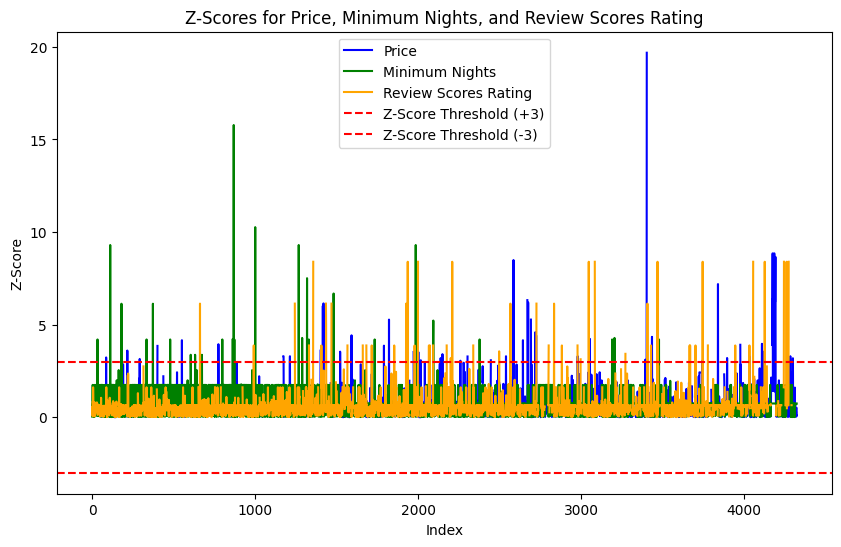

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def remove_outliers_z_score(dataframe, outlier_columns, threshold=3):
    """
    Remove outliers from the DataFrame using Z-Score method and store them in a new DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    outlier_columns (list): List of columns to check for outliers.
    threshold (float): Z-score threshold for detecting outliers (default is 3).

    Returns:
    pd.DataFrame: DataFrame without outliers.
    pd.Series: Series with the number of outliers detected per column.
    """
    # Standardizing (z-scoring) the data for outlier detection
    z_scores = np.abs((dataframe[outlier_columns] - dataframe[outlier_columns].mean()) / dataframe[outlier_columns].std())

    # Detecting outliers with a z-score threshold
    outliers = z_scores > threshold

    # Number of outliers per column
    outliers_per_column = outliers.sum()

    # Displaying the number of outliers per column
    print("Number of outliers per column:")
    print(outliers_per_column)

    # Remove outliers from the original DataFrame
    dataframe_no_outliers = dataframe[~outliers.any(axis=1)]

    # Plotting the z-scores with colors for each property
    plt.figure(figsize=(10, 6))

    # Plot each property with a different color
    plt.plot(z_scores['price'], label='Price', color='blue')
    plt.plot(z_scores['minimum_nights'], label='Minimum Nights', color='green')
    plt.plot(z_scores['review_scores_rating'], label='Review Scores Rating', color='orange')

    # Add z-score threshold line at the specified threshold
    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Z-Score Threshold (+{threshold})')
    plt.axhline(y=-threshold, color='red', linestyle='--', label=f'Z-Score Threshold (-{threshold})')

    # Add labels and title
    plt.title('Z-Scores for Price, Minimum Nights, and Review Scores Rating')
    plt.xlabel('Index')
    plt.ylabel('Z-Score')

    # Add legend to show which color represents which property
    plt.legend()

    # Show the plot
    plt.show()

    return dataframe_no_outliers, outliers_per_column

listings_no_outliers_Z, outliers_per_column = remove_outliers_z_score(listings, outlier_columns)


Calculating summary statistics after dropping outliers according to IQR method

In [25]:
#IQR
display_summary_statistics(listings_no_outliers_IQR, numerical_features)

#Z Score
display_summary_statistics(listings_no_outliers_Z, numerical_features)

Summary Statistics:
             price  minimum_nights  maximum_nights  review_scores_rating
count  2264.000000     2264.000000     2264.000000           2264.000000
mean    205.003092       10.915194      507.308304              4.798511
std     114.264110       13.477100      416.010353              0.193128
min      25.000000        1.000000        3.000000              4.200000
25%     115.000000        1.000000      180.000000              4.690000
50%     190.000000        2.000000      365.000000              4.840000
75%     274.000000       29.000000     1125.000000              4.970000
max     542.000000       70.000000     1125.000000              5.000000
Summary Statistics:
             price  minimum_nights  maximum_nights  review_scores_rating
count  3420.000000     4177.000000     4177.000000           3215.000000
mean    219.683041       26.733780      594.800814              4.755154
std     153.030061       31.574389      432.298774              0.273621
min      25

Visualizing after outlier removal using IQR

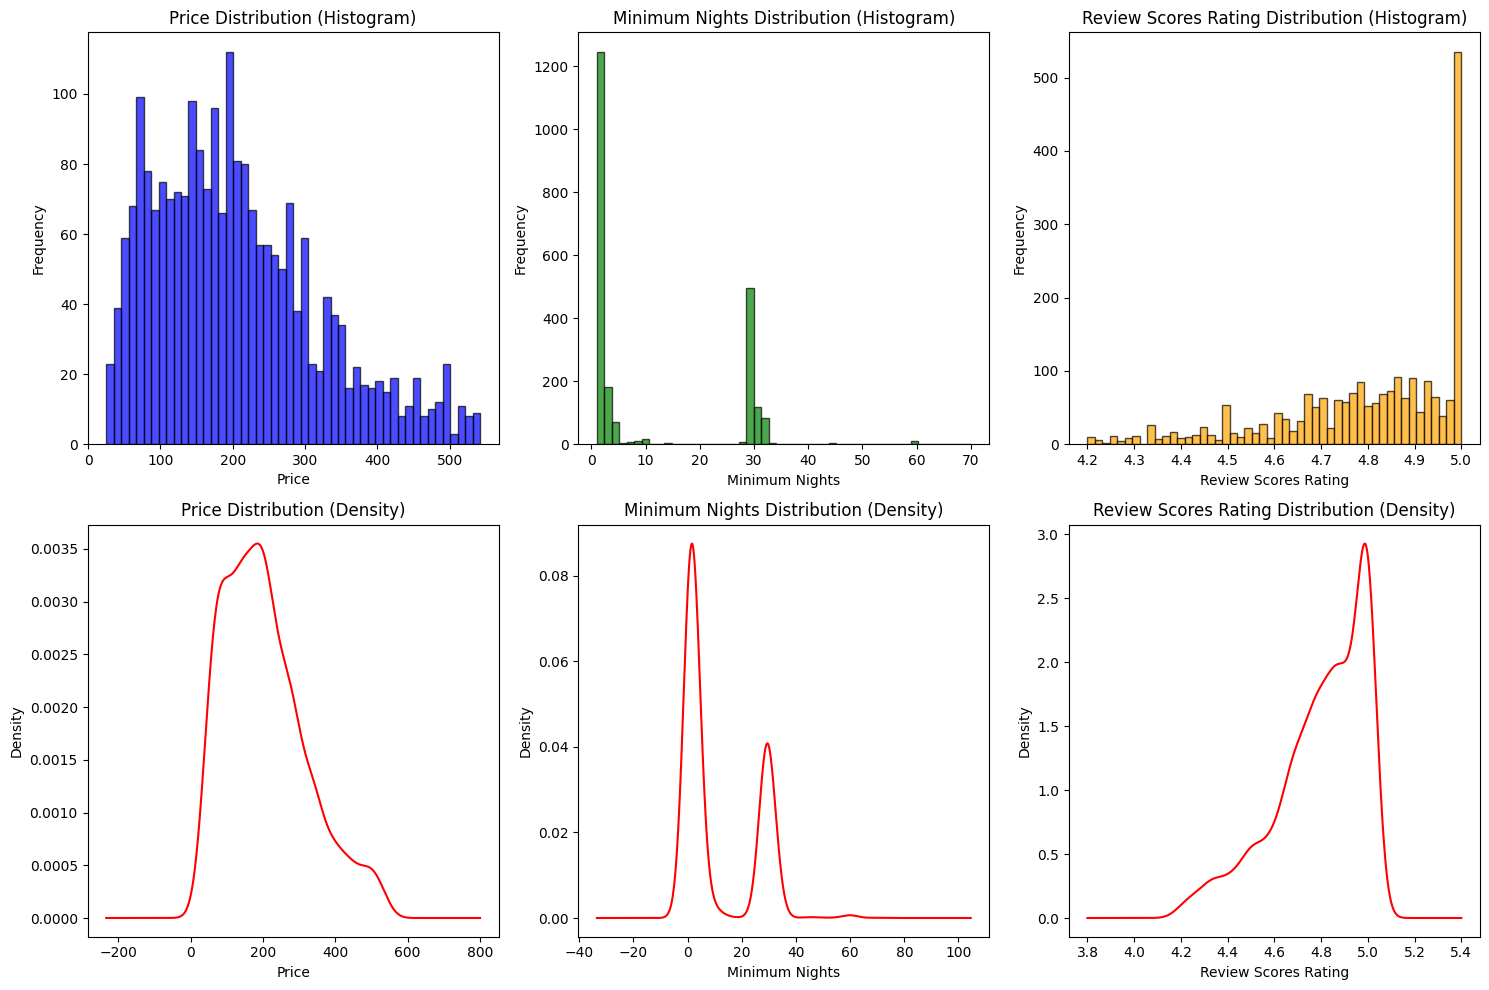

In [26]:
plot_numerical_distributions(listings_no_outliers_IQR)

Visualizing after outlier removal using Z Score

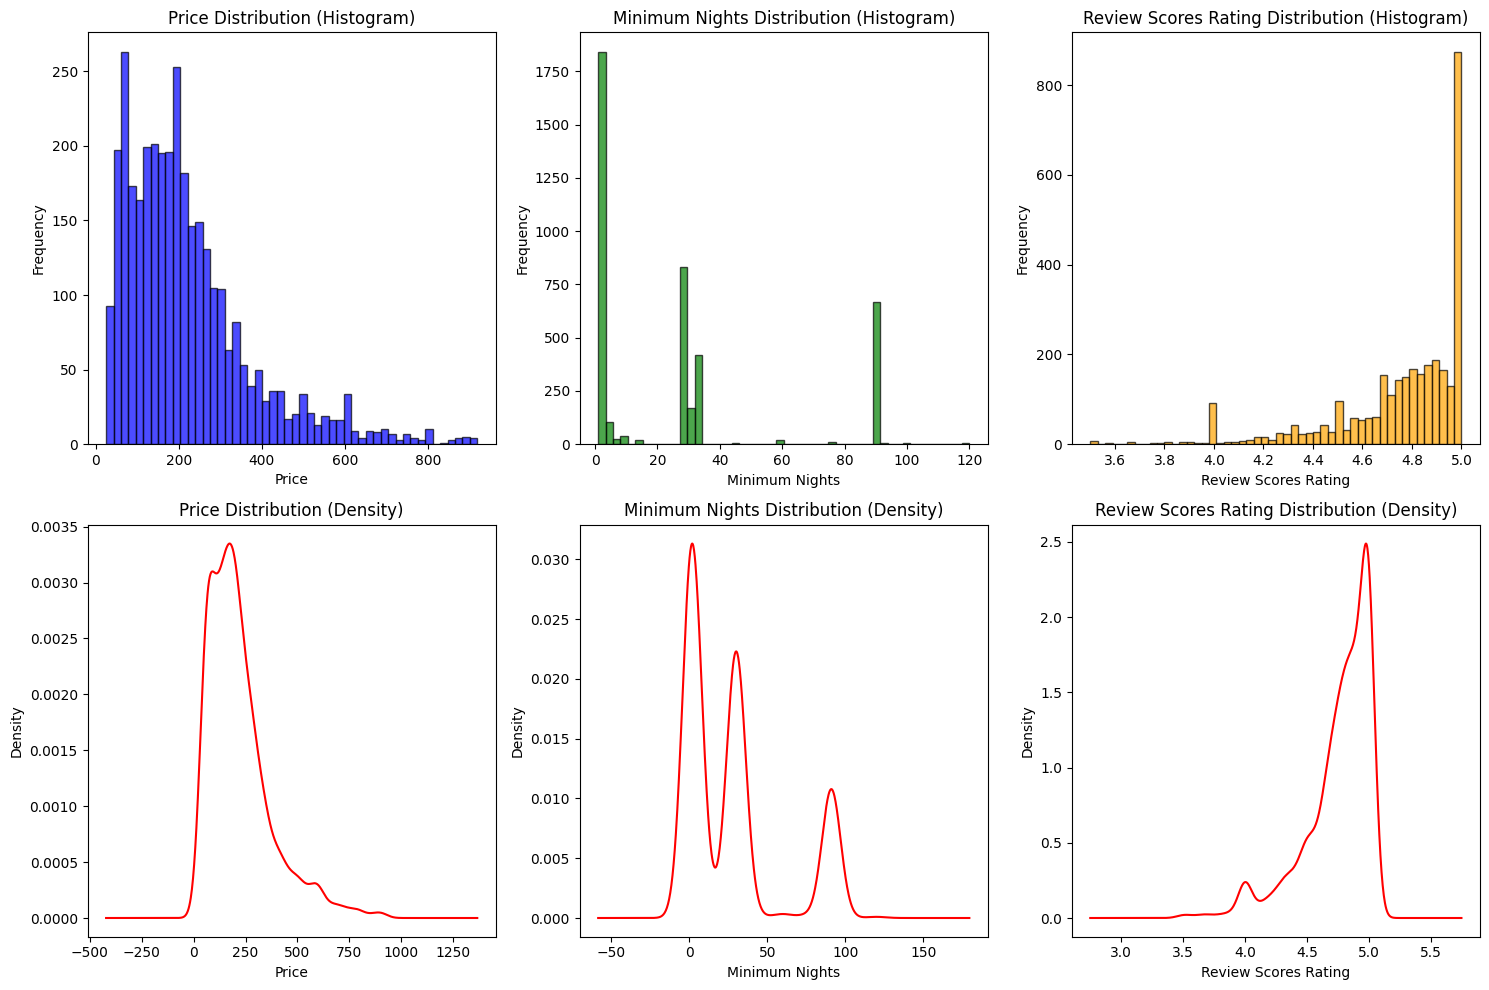

In [27]:
plot_numerical_distributions(listings_no_outliers_Z)

# Text Length

Create a new feature that measures the length of each
review (number of words or characters). Determine if the length of a review
correlates with its sentiment or the review scores.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3326 entries, 0 to 3325
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   listing_id               3326 non-null   int64  
 1   avg_review_length_words  3326 non-null   float64
 2   review_scores_rating     3326 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 78.1 KB
None
Correlation between average review length and review score:
                         avg_review_length_words  review_scores_rating
avg_review_length_words                 1.000000             -0.234005
review_scores_rating                   -0.234005              1.000000


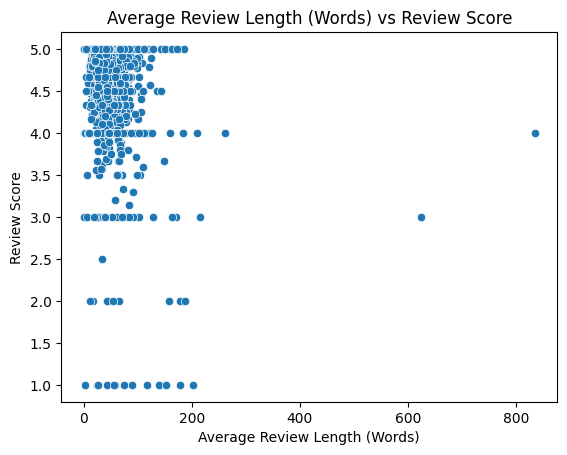

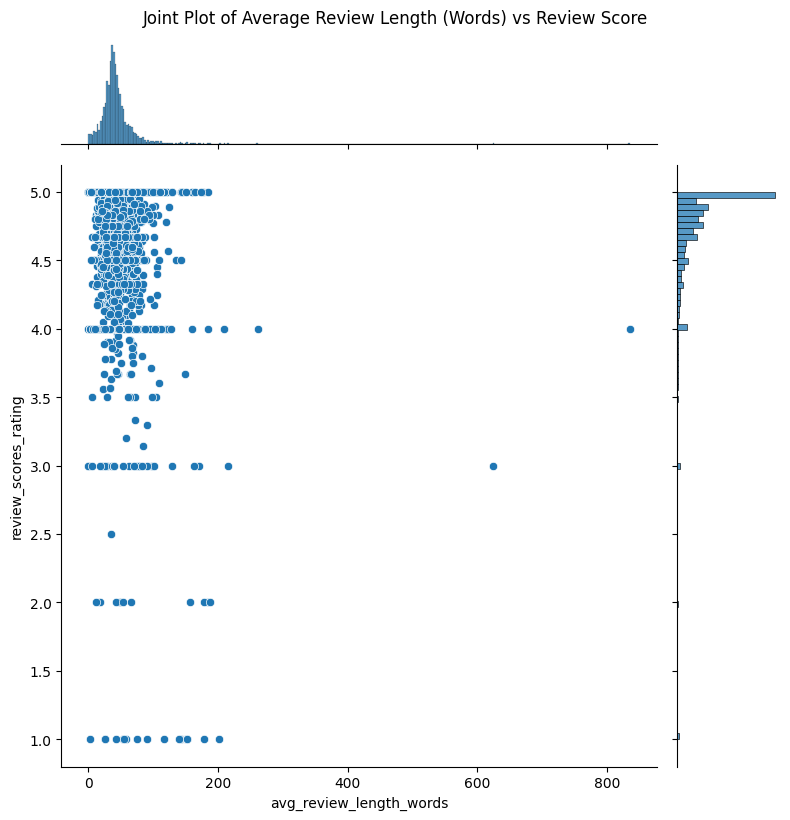

In [28]:
# Duplicate the 'id' column and name it 'listing_id' in listing dataset
listings['listing_id'] = listings['id']

# Fill missing values in the 'comments' column with an empty string
reviews['comments'] = reviews['comments'].fillna('')

# Define a function to clean HTML tags and special characters from the comments
def clean_text(text):
    # Ensure that the text is a string
    if not isinstance(text, str):
        return text

    # Remove HTML tags
    if '<' in text or '>' in text:  # Check if it contains HTML-like tags
        text = BeautifulSoup(text, "html.parser").get_text()

    # Remove special characters (keeping only letters, numbers, and basic punctuation)
    text = re.sub(r'[^A-Za-z0-9.,!?\'\s]', '', text)

    return text

# Apply the cleaning function to the 'comments' column
reviews['comments'] = reviews['comments'].apply(clean_text)

# Calculate the length of each review (both in words and characters)
reviews['review_length_words'] = reviews['comments'].apply(lambda x: len(str(x).split()))
reviews['review_length_chars'] = reviews['comments'].apply(lambda x: len(str(x)))

# Calculate the sentiment polarity of each review
reviews['sentiment'] = reviews['comments'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Group by 'listing_id' and calculate the average review length (in words) for each listing
avg_review_length = reviews.groupby('listing_id')['review_length_words'].mean().reset_index()
avg_review_length.columns = ['listing_id', 'avg_review_length_words']

# Merge the average review length with the cumulative review score from the 'listings' dataset
merged_data = avg_review_length.merge(listings[['listing_id', 'review_scores_rating']], on='listing_id', how='left')

# Drop any rows where review length or review score is missing
merged_data = merged_data.dropna(subset=['avg_review_length_words', 'review_scores_rating'])

# Display the merged data information
print(merged_data.info())

# Calculate the correlation between the average review length and the review score
correlation = merged_data[['avg_review_length_words', 'review_scores_rating']].corr()
print("Correlation between average review length and review score:")
print(correlation)

# Visualize the correlation using a scatter plot
sns.scatterplot(x='avg_review_length_words', y='review_scores_rating', data=merged_data)
plt.title('Average Review Length (Words) vs Review Score')
plt.xlabel('Average Review Length (Words)')
plt.ylabel('Review Score')
plt.show()

# Joint plot to show correlation between average review length and review score
sns.jointplot(x='avg_review_length_words', y='review_scores_rating', data=merged_data, kind='scatter', height=8)
plt.suptitle('Joint Plot of Average Review Length (Words) vs Review Score', y=1.02)
plt.show()


# Keyword Extraction

Identify and count the occurrence of specific keywords (e.g., "clean,"
"comfortable," "noisy") in the reviews. Generate new features based on the
presence of these keywords, which might influence guest satisfaction

In [29]:
# Define positive and negative keywords
positive_keywords = ["great", "clean", "nice", "comfortable", "friendly", "spacious", "amazing", "fabulous"]
negative_keywords = ["uncomfortable", "noisy", "bad", "dirty", "terrible", "unpleasant", "poor"]

# Function to count keyword occurrences in a review, handling NaN values
def count_keywords(review, keywords):
    # Convert the review to a string to avoid errors
    review = str(review).lower()
    # Count occurrences of each keyword
    keyword_counts = {keyword: review.count(keyword) for keyword in keywords}

    return keyword_counts

# Apply the function and convert the result to a DataFrame for positive keywords
positive_keyword_counts_df = reviews["comments"].apply(lambda x: pd.Series(count_keywords(x, positive_keywords)))

# Add the 'positive_' prefix to the column names for positive keywords
positive_keyword_counts_df.columns = ['positive_' + col for col in positive_keyword_counts_df.columns]

# Join the positive keyword counts with the original DataFrame
reviews = reviews.join(positive_keyword_counts_df)

# Apply the function and convert the result to a DataFrame for negative keywords
negative_keyword_counts_df = reviews["comments"].apply(lambda x: pd.Series(count_keywords(x, negative_keywords)))

# Add the 'negative_' prefix to the column names for negative keywords
negative_keyword_counts_df.columns = ['negative_' + col for col in negative_keyword_counts_df.columns]

# Join the negative keyword counts with the original DataFrame
reviews = reviews.join(negative_keyword_counts_df)

# Aggregate keyword counts for each motel
aggregated_reviews = reviews.groupby('listing_id').sum().reset_index()

# Save aggregated reviews to a CSV file
aggregated_reviews.to_csv('aggregated_reviews.csv', index=False)

# List of columns to merge from 'aggregated_reviews'
columns_to_merge = [
    'listing_id', 'positive_great', 'positive_clean', 'positive_nice',
    'positive_comfortable', 'positive_friendly', 'positive_spacious',
    'positive_amazing', 'positive_fabulous', 'negative_uncomfortable',
    'negative_noisy', 'negative_bad', 'negative_dirty', 'negative_terrible',
    'negative_unpleasant', 'negative_poor'
]

# Select only the necessary columns from aggregated_reviews
aggregated_selected = aggregated_reviews[columns_to_merge]

# Merge using 'listing_id' from 'aggregated_reviews' and 'id' from 'listings'
listings = listings.merge(aggregated_selected, left_on='id', right_on='listing_id', how='left')

# Fill NaN values with 0 (in case some motels have no reviews)
listings = listings.fillna(0)

listings.to_csv('listings_with_keywords.csv', index=False)

# Select specific columns to display
columns_to_display = ['id', 'name', 'review_scores_rating'] + [f'positive_{kw}' for kw in positive_keywords] + [f'negative_{kw}' for kw in negative_keywords]
result = listings[columns_to_display]

# Debugging: Print the final result DataFrame
print("Final result DataFrame:")
print(result.head())

# Save the result to a CSV file
result.to_csv('result_keywords.csv', index=False)


Final result DataFrame:
      id                                              name  \
0   3781                         HARBORSIDE-Walk to subway   
1   5506    ** Fort Hill Inn Private! Minutes to center!**   
2   6695     Fort Hill Inn *Sunny* 1 bedroom, condo duplex   
3   8789               Curved Glass Studio/1bd facing Park   
4  10811  Back Bay Apt Studio-3 blocks to Pru center & "T"   

   review_scores_rating  positive_great  positive_clean  positive_nice  \
0                  4.96            22.0             6.0            7.0   
1                  4.79            61.0            39.0           33.0   
2                  4.81            68.0            44.0           32.0   
3                  4.69            21.0             6.0            7.0   
4                  4.33             2.0             1.0            5.0   

   positive_comfortable  positive_friendly  positive_spacious  \
0                   3.0                0.0                1.0   
1                  34.0     